In [1]:
import pandas as pd
import numpy as np
import os
import sys
import scanpy as sc
import anndata as ad
import scipy
import gget
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# local 
import utils as ut

In [2]:
# load predictions
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/hypomap/merged_predictions.csv"
df = pd.read_csv(fpath)
print(f"{df.shape=}")

for c in df.columns:
    if not c == 'index':
        df[f'{c}_clean'] = df[c].apply(lambda x: x.split(":")[1]).astype(str)


# load clustering results
fpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/embedding.csv"
cdf = pd.read_csv(fpath)
print(f"{cdf.shape=}")

# merge 'em'
df = pd.merge(df, cdf, 
              how='left',
              left_on='index',
              right_on='index')


# clean-up the cell type
df = df.set_index('index')


print(f"{df.shape=}")
df.head()

df.shape=(43312, 5)
cdf.shape=(43312, 3)
df.shape=(43312, 10)


,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2
index,,,,,,,,,,
AAACCCACATGGCTGC-1_fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050
AAACCCAGTATATGGA-1_fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433
AAACCCAGTCAACACT-1_fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299
AAACCCATCCCGTGAG-1_fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034
AAACCCATCGAACTCA-1_fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702


In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/h5ad_files/"

data = {}

for f in os.listdir(dirpath):
    fullpath = f"{dirpath}{f}"
    key = f.replace(".h5ad", "")

    batch_andata = sc.read(fullpath)
    batch_andata.obs['batch'] = key
    data[key] = batch_andata
    
adata = ad.concat(data, index_unique="_") # combine all the experiments
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 43312 × 32285
    obs: 'batch'

In [4]:
# add the metadata into the object
adata.obs = adata.obs.join(df, 
                           how='left')

adata.obs['Diet'] = adata.obs['batch'].apply(lambda x: x.split("_")[0])
adata.obs['Sex'] = adata.obs['batch'].apply(lambda x: x.split("_")[1])

adata.obsm['X_umap'] = adata.obs[['UMAP1', 'UMAP2']].copy().to_numpy()

adata.obs.head()

,batch,reference_embedding_C7_named,reference_embedding_C25_named,C25_named,C7_named,reference_embedding_C7_named_clean,reference_embedding_C25_named_clean,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex
AAACCCACATGGCTGC-1_fasted_m,fasted_m,C7-2: GABA,C25-11: GABA-1,C25-10: GABA-2,C7-2: GABA,GABA,GABA-1,GABA-2,GABA,-6.741960,14.083050,fasted,m
AAACCCAGTATATGGA-1_fasted_m,fasted_m,C7-2: GABA,C25-13: GABA-4,C25-1: GLU-1,C7-2: GABA,GABA,GABA-4,GLU-1,GABA,2.378481,2.956433,fasted,m
AAACCCAGTCAACACT-1_fasted_m,fasted_m,C7-5: Immune,C25-21: Immune,C25-21: Immune,C7-5: Immune,Immune,Immune,Immune,Immune,1.525248,-6.143299,fasted,m
AAACCCATCCCGTGAG-1_fasted_m,fasted_m,C7-4: Oligo+Precursor,C25-19: Oligodendrocytes,C25-19: Oligodendrocytes,C7-4: Oligo+Precursor,Oligo+Precursor,Oligodendrocytes,Oligodendrocytes,Oligo+Precursor,15.965842,14.408034,fasted,m
AAACCCATCGAACTCA-1_fasted_m,fasted_m,C7-1: GLU,C25-2: GLU-2,C25-2: GLU-2,C7-1: GLU,GLU,GLU-2,GLU-2,GLU,-2.045243,7.478702,fasted,m


In [5]:
"""some simple processing """

adata.layers["counts"] = adata.X.copy() # store the raw counts

""" Add a metadata column """
adata.obs['broad_type'] = adata.obs['reference_embedding_C25_named_clean'].apply(lambda x: x.split("-")[0])

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.calculate_qc_metrics(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.combat(adata) # regress out batch effects

sc.pp.highly_variable_genes(adata, 
                            min_mean=0.0125, 
                            max_mean=3, 
                            min_disp=0.5)

sc.tl.pca(adata, n_comps=40)

adata

... storing 'batch' as categorical
... storing 'reference_embedding_C7_named' as categorical
... storing 'reference_embedding_C25_named' as categorical
... storing 'C25_named' as categorical
... storing 'C7_named' as categorical
... storing 'reference_embedding_C7_named_clean' as categorical
... storing 'reference_embedding_C25_named_clean' as categorical
... storing 'C25_named_clean' as categorical
... storing 'C7_named_clean' as categorical
... storing 'Diet' as categorical
... storing 'Sex' as categorical
... storing 'broad_type' as categorical


AnnData object with n_obs × n_vars = 42937 × 25060
    obs: 'batch', 'reference_embedding_C7_named', 'reference_embedding_C25_named', 'C25_named', 'C7_named', 'reference_embedding_C7_named_clean', 'reference_embedding_C25_named_clean', 'C25_named_clean', 'C7_named_clean', 'UMAP1', 'UMAP2', 'Diet', 'Sex', 'broad_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [6]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

  Sun1     batch     0
0    +  fasted_f  6654
3    -  fasted_f  5517
2    +  fasted_m  5547
6    -  fasted_m  4680
4    +     fed_f  5219
1    -     fed_f  6071
7    +     fed_m  4294
5    -     fed_m  4955


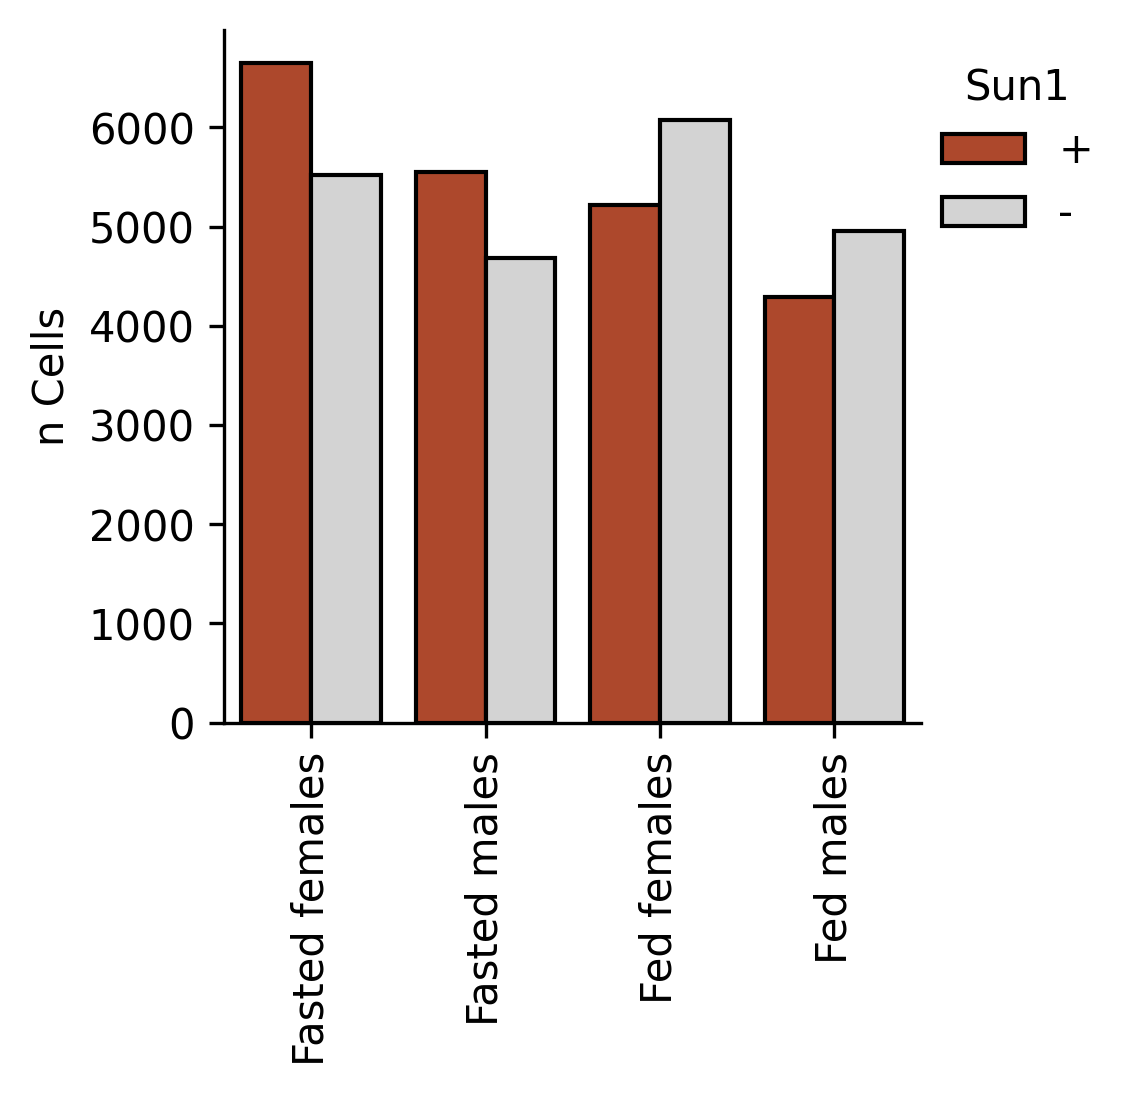

In [7]:
"""Add sun1 column """
gene = 'Sun1'
mask = np.ravel(adata[:, [gene]].layers['counts'].todense() > 0)
adata.obs['Sun1'] = np.where(mask, '+', '-')
adata.obs['sun1'] = np.where(mask, 1, 0)

pdf = adata.obs[['Sun1', 'batch']].value_counts().reset_index(drop=False)
pdf = pdf.sort_values(by=['batch', 'Sun1'])
print(pdf)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

keyMap = {
    'fasted_f' : 'Fasted females',
    'fed_f' : 'Fed females',
    'fasted_m' : 'Fasted males',
    'fed_m' : 'Fed males',
}

pdf['batch_name'] = pdf['batch'].map(keyMap)

sns.barplot(data=pdf, 
            x='batch_name',
            hue='Sun1',
            ec='k',
            palette=['#c23c17', 'lightgrey'],
            y=0)


sns.despine()
plt.ylabel('n Cells')
plt.xlabel('')

plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(plt.gca(),
                loc='upper right',
                frameon=False,
                bbox_to_anchor=(1.3, 1))

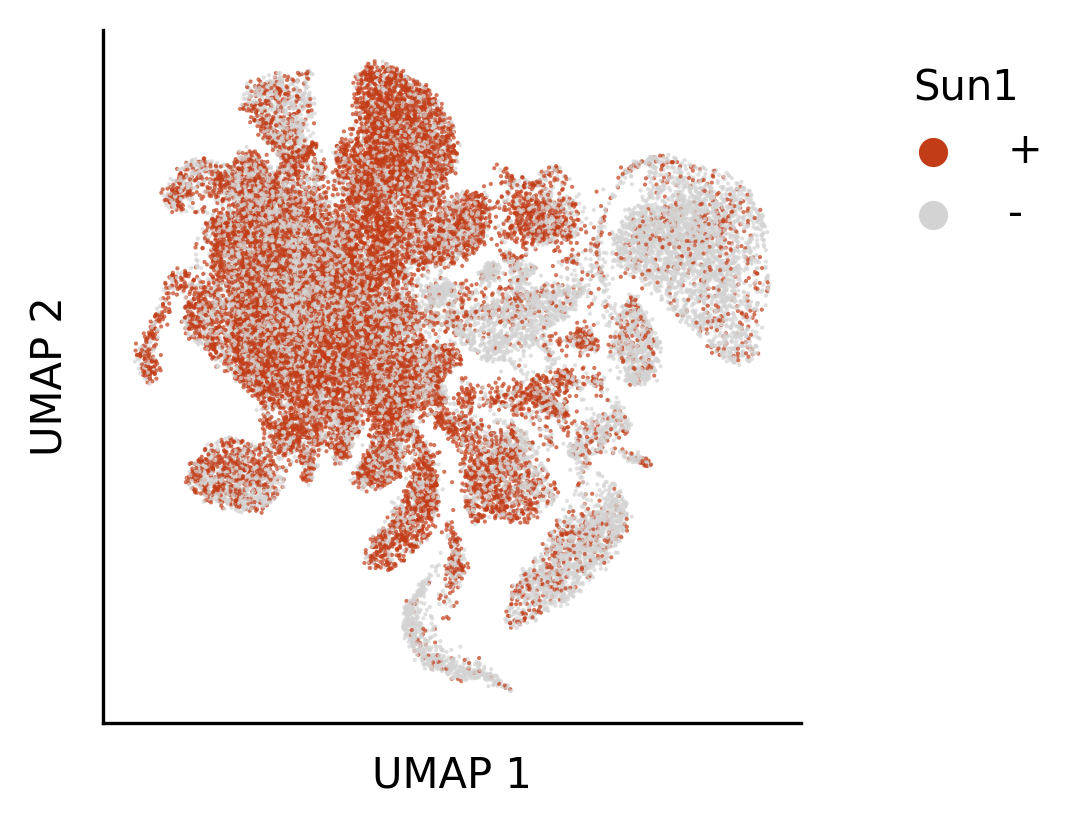

In [8]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3 

sns.scatterplot(data=adata.obs,
                x='UMAP1',
                y='UMAP2',
                # c=adata.obs['color'].to_list(),
                hue='Sun1',
                # hue_order=sorted(adata.obs[key].unique()),
                palette=['#c23c17', 'lightgrey'],
                ec='None',
                alpha=0.7,
                s=1)

plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")

plt.yticks([])
plt.xticks([])

sns.move_legend(plt.gca(),
                title='Sun1',
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.4, 1))
sns.despine()

,C7_named_clean,pos_count,count,neg_count,percent
0,Astro-Ependymal,433,2095,1662,0.206683
1,GABA,7478,13852,6374,0.539850
2,GLU,12780,21249,8469,0.601440
3,Immune,116,771,655,0.150454
4,Oligo+Precursor,679,4163,3484,0.163104


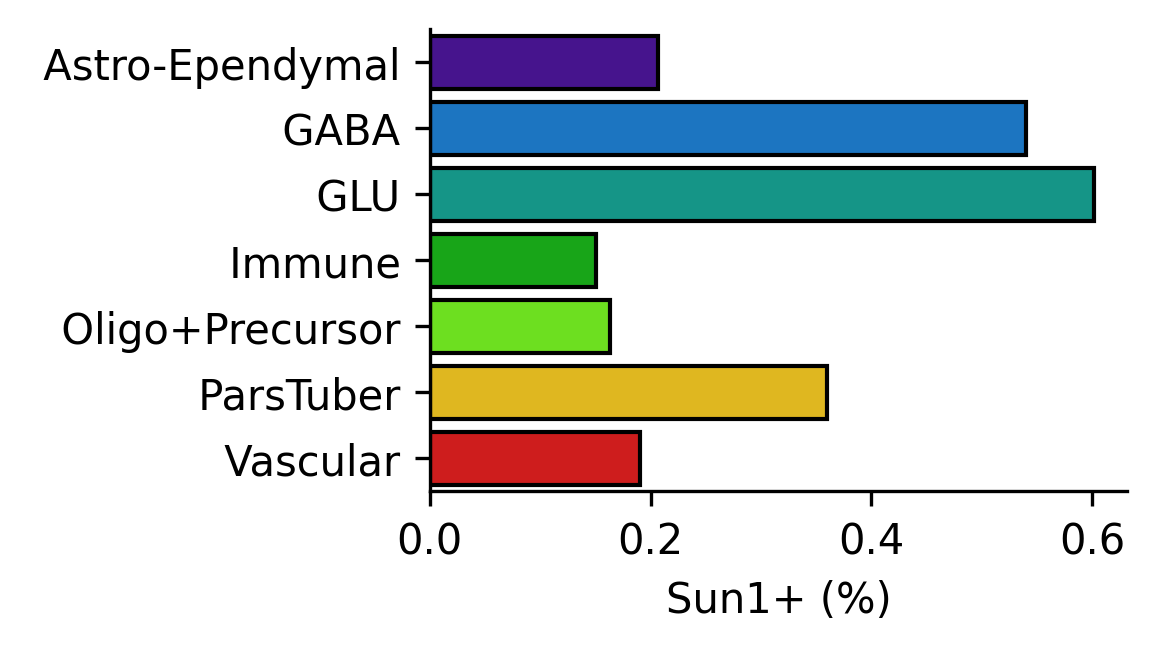

In [9]:
pdf = adata.obs.copy()

pdf = pdf.groupby(['C7_named_clean']).agg(
    pos_count = ('sun1', 'sum'),
    count = ('sun1', 'count'),
).reset_index(drop=False)


pdf['neg_count'] = pdf['count'] - pdf['pos_count']
pdf['percent'] = pdf['pos_count'] / pdf['count']

# pdf = pd.melt(pdf, id_vars='C7_named_clean')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2 

sns.barplot(data=pdf, 
            y='C7_named_clean',
            x='percent',
            palette='nipy_spectral',
            ec='k',)

plt.ylabel("")
plt.xlabel("Sun1+ (%)")
# plt.xlabel("n Cells (Sun1+)")
# plt.xlabel("n Cells (Sun1-)")

sns.despine()

pdf.head()

,C25_named_clean,pos_count,count,neg_count,percent
0,Astrocytes,395,1711,1316,0.230859
1,Ependymal-like,108,449,341,0.240535
2,Fibroblasts,24,193,169,0.124352
3,GABA-2,1494,2859,1365,0.522560
4,GABA-3,1136,2141,1005,0.530593


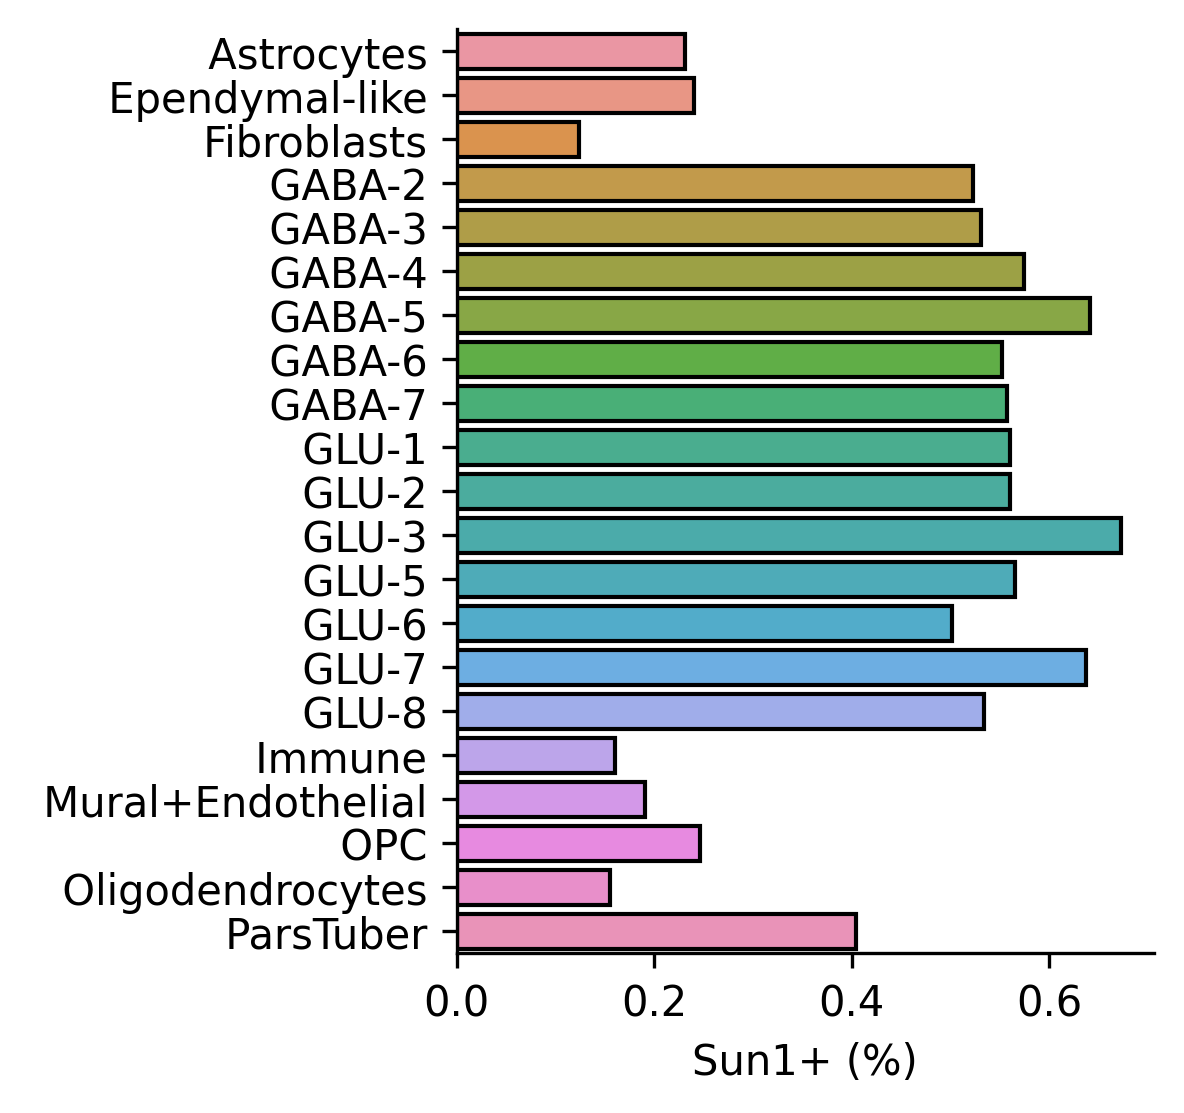

In [10]:
pdf = adata.obs.copy()

pdf = pdf.groupby(['C25_named_clean']).agg(
    pos_count = ('sun1', 'sum'),
    count = ('sun1', 'count'),
).reset_index(drop=False)


pdf['neg_count'] = pdf['count'] - pdf['pos_count']
pdf['percent'] = pdf['pos_count'] / pdf['count']

# pdf = pd.melt(pdf, id_vars='C7_named_clean')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 4

sns.barplot(data=pdf, 
            y='C25_named_clean',
            x='percent',
            # palette='nipy_spectral',
            ec='k',)

plt.ylabel("")
plt.xlabel("Sun1+ (%)")
# plt.xlabel("n Cells (Sun1+)")
# plt.xlabel("n Cells (Sun1-)")

sns.despine()

pdf.head()

pos.shape=(21714, 16) neg.shape=(21223, 16)


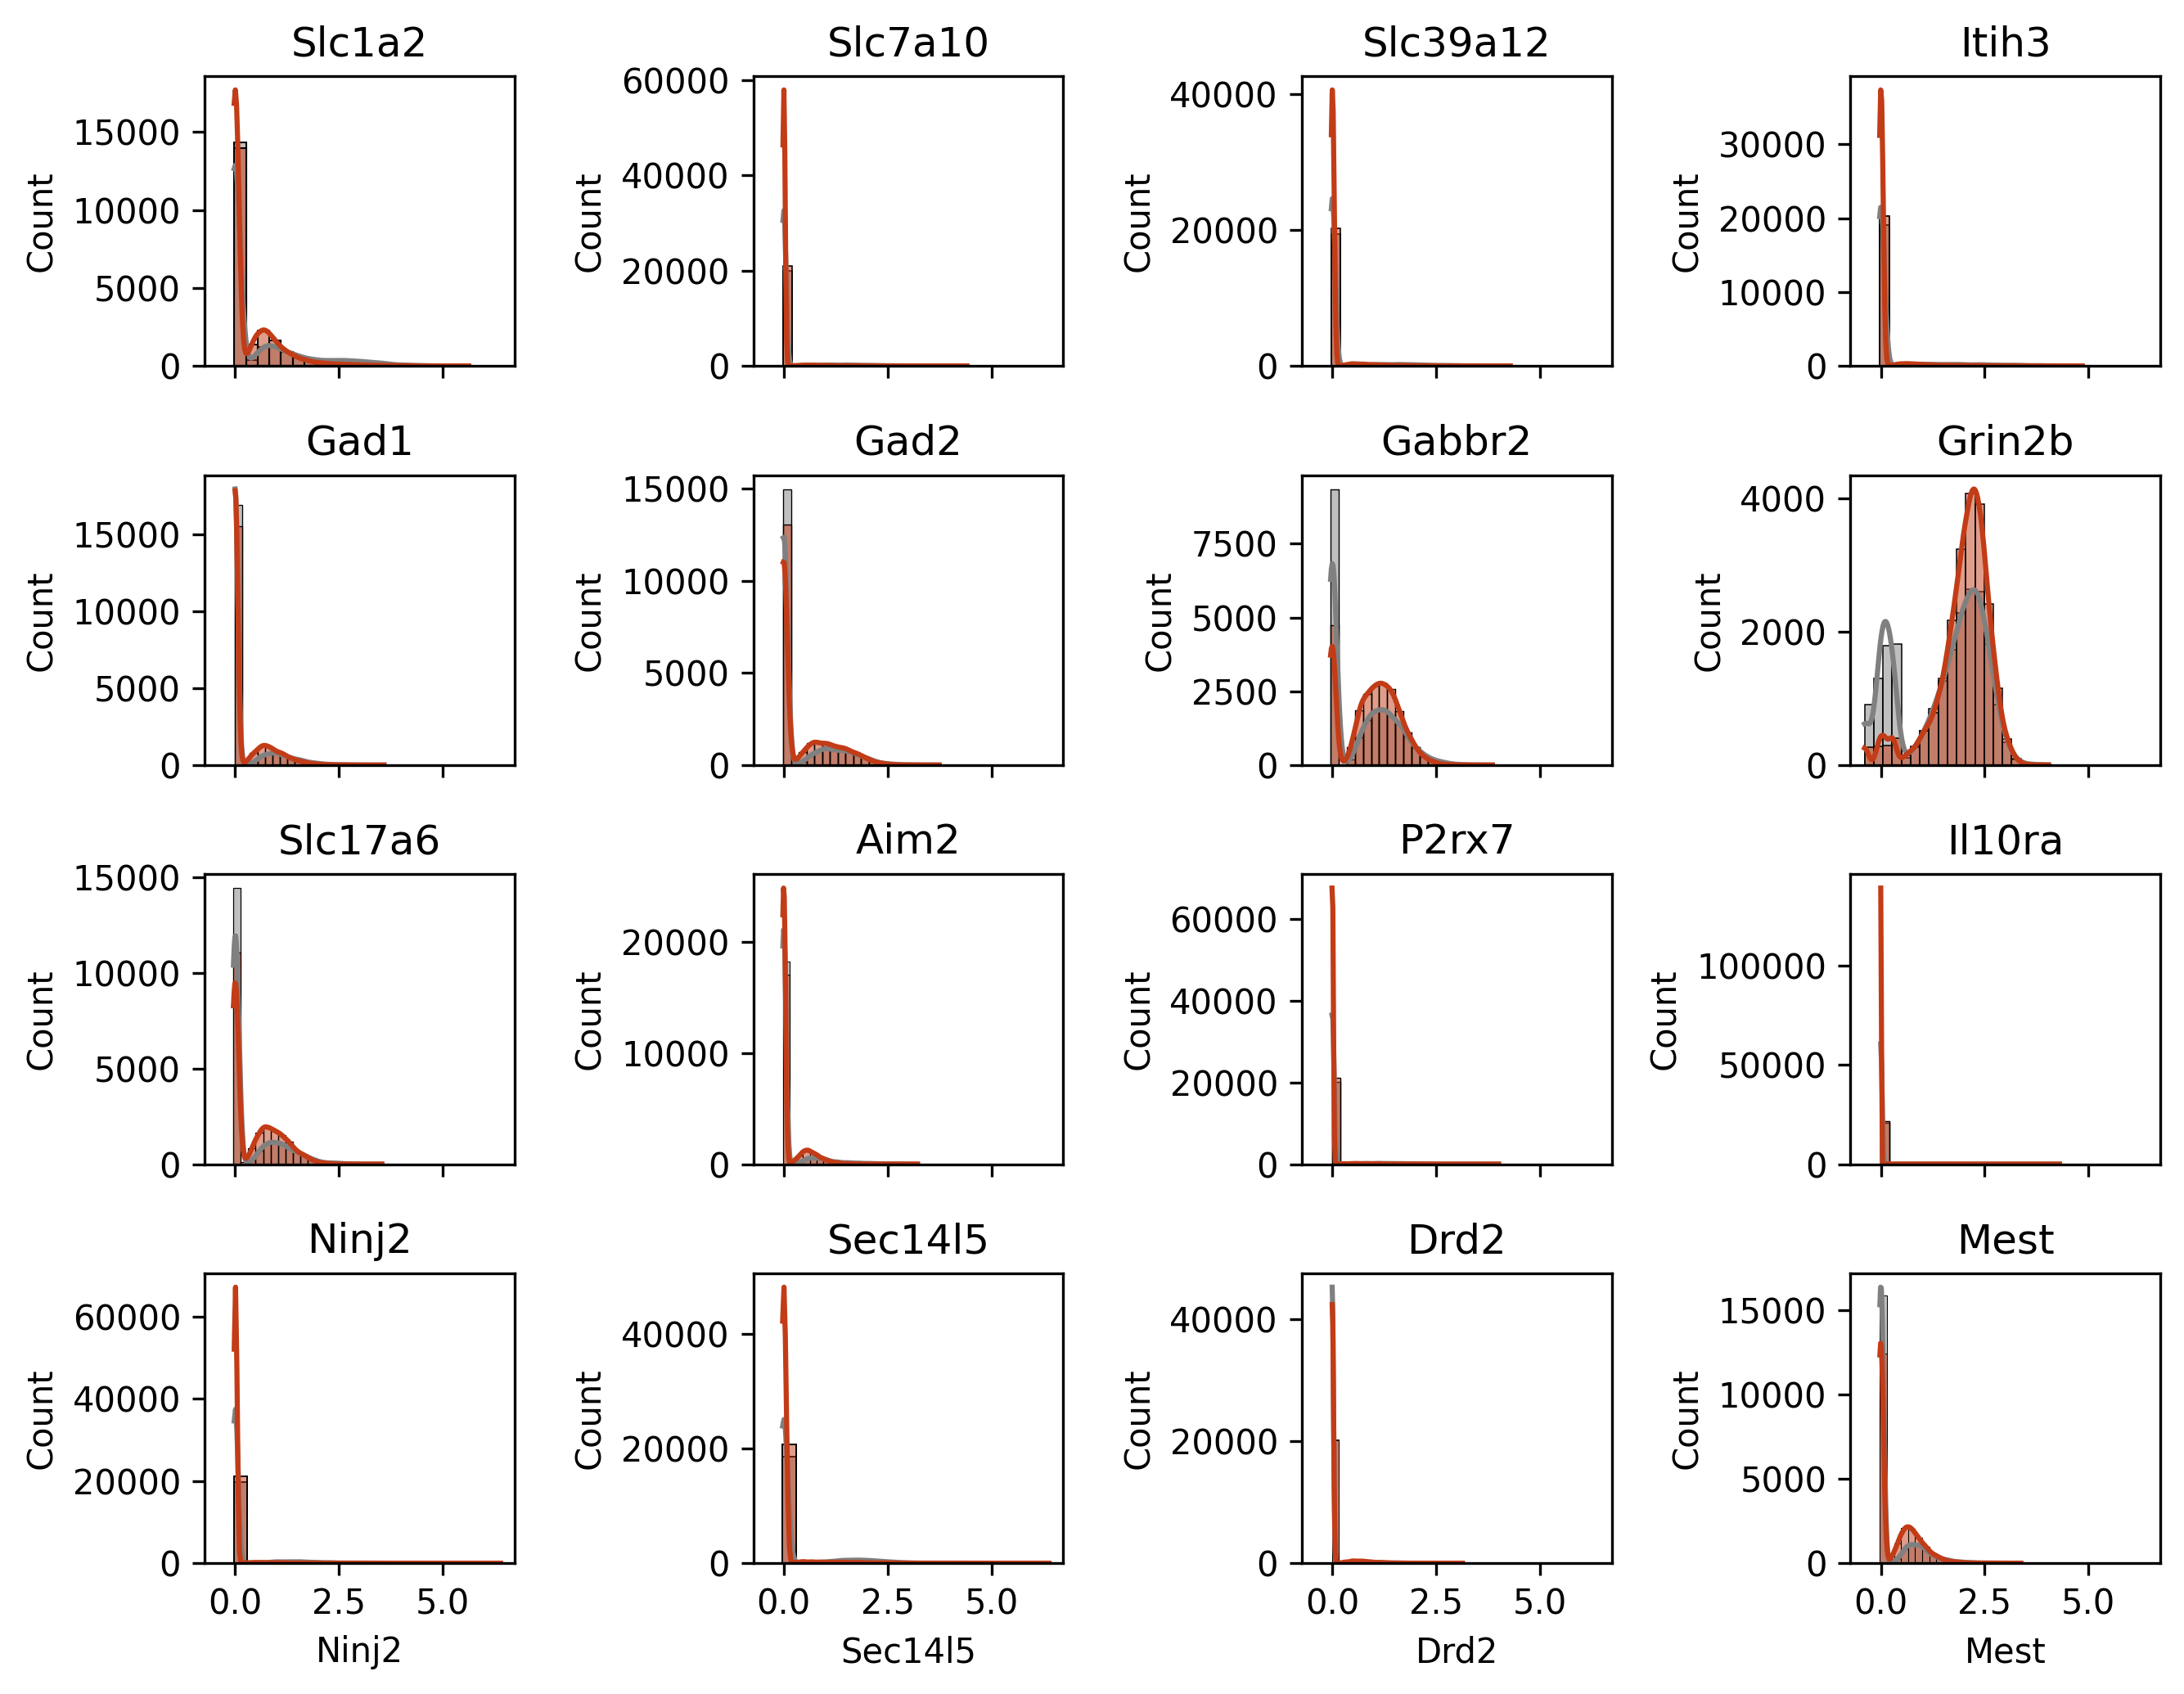

In [11]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pos['type'] = 'positive'
neg['type'] = 'negative'

pdf = pd.concat([pos, neg])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9, 7

fig, axs = plt.subplots(4, 4, sharex=True)
axs = axs.ravel()

alpha_tol = 0.01

for i, g in enumerate(query):

    p = pdf[pdf['type'] == 'positive'][g].to_numpy()
    n = pdf[pdf['type'] == 'negative'][g].to_numpy()

    # score, p_val = scipy.stats.ranksums(p, n,
    #                                     alternative='two-sided')

    # sig = ""
    # if p_val <= alpha_tol:
    #     sig="*"

    # print(f"Gene: {g} {p_val=:4f}")

    sns.histplot(data=pdf, 
                 x=g,
                 bins=20,
                 hue='type',
                 kde=True,
                 legend=False,
                 palette=['#c23c17', 'grey'],
                 # lw=1,
                 ax=axs[i])

    axs[i].set_title(f"{g}")
    
    # break
    
# plt.yscale('log')
plt.tight_layout()

In [12]:
""" Distribution of marker gene expression """
query = [
    'Slc1a2',
    'Slc7a10',
    'Slc39a12',
    'Itih3',
    'Gad1',
    'Gad2',
    'Gabbr2',
    'Grin2b',
    'Slc17a6',
    'Aim2',
    'P2rx7',
    'Il10ra',
    'Ninj2',
    'Sec14l5', 
    'Drd2', 
    'Mest',
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
pdf.head()

pos.shape=(21714, 16) neg.shape=(21223, 16)
(42937, 33)


,Slc1a2,Slc7a10,Slc39a12,Itih3,Gad1,Gad2,Gabbr2,Grin2b,Slc17a6,Aim2,...,C25_named_clean,C7_named_clean,UMAP1,UMAP2,Diet,Sex,broad_type,n_genes,Sun1,sun1
AAACCCACATGGCTGC-1_fasted_m,0.020305,0.00346,0.004116,-0.000027,0.721050,1.663285,1.473406,2.851289,0.028758,1.184728,...,GABA-2,GABA,-6.741960,14.083050,fasted,m,GABA,3847,+,1
AAACCCAGTATATGGA-1_fasted_m,0.020305,0.00346,0.004116,-0.000027,0.604336,1.257682,1.290245,2.048812,0.696056,0.003766,...,GLU-1,GABA,2.378481,2.956433,fasted,m,GABA,4724,+,1
AAACCCATCGAACTCA-1_fasted_m,0.020305,0.00346,0.721951,-0.000027,-0.002628,-0.009230,1.076444,2.019400,0.747230,0.003766,...,GLU-2,GLU,-2.045243,7.478702,fasted,m,GLU,4176,+,1
AAACCCATCTTGCGCT-1_fasted_m,0.020305,0.00346,0.004116,-0.000027,-0.002628,-0.009230,1.224157,2.272292,0.865654,0.795353,...,GLU-2,GLU,-0.476919,12.656019,fasted,m,GLU,5810,+,1
AAACGAAAGCGTTAGG-1_fasted_m,0.020305,0.00346,0.004116,-0.000027,-0.002628,0.666142,1.383530,2.160064,0.760432,0.003766,...,GLU-8,GABA,-4.602933,4.117253,fasted,m,GLU,4513,+,1


In [13]:
res = []

for ctype, group in pdf.groupby('C7_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

,ctype,index,variable,value
0,Astro-Ependymal,Slc1a2,logfoldchange,0.001158
1,Astro-Ependymal,Slc7a10,logfoldchange,-0.000805
2,Astro-Ependymal,Slc39a12,logfoldchange,0.029721
3,Astro-Ependymal,Itih3,logfoldchange,0.000433
4,Astro-Ependymal,Gad1,logfoldchange,0.030057


ctype
 Astro-Ependymal    0.030768
 GABA               0.049719
 GLU                0.045663
 Immune             0.458510
 Oligo+Precursor    0.121990
 ParsTuber          0.083998
 Vascular           0.252581
dtype: float64


Text(0.5, 493.9322916666667, '')

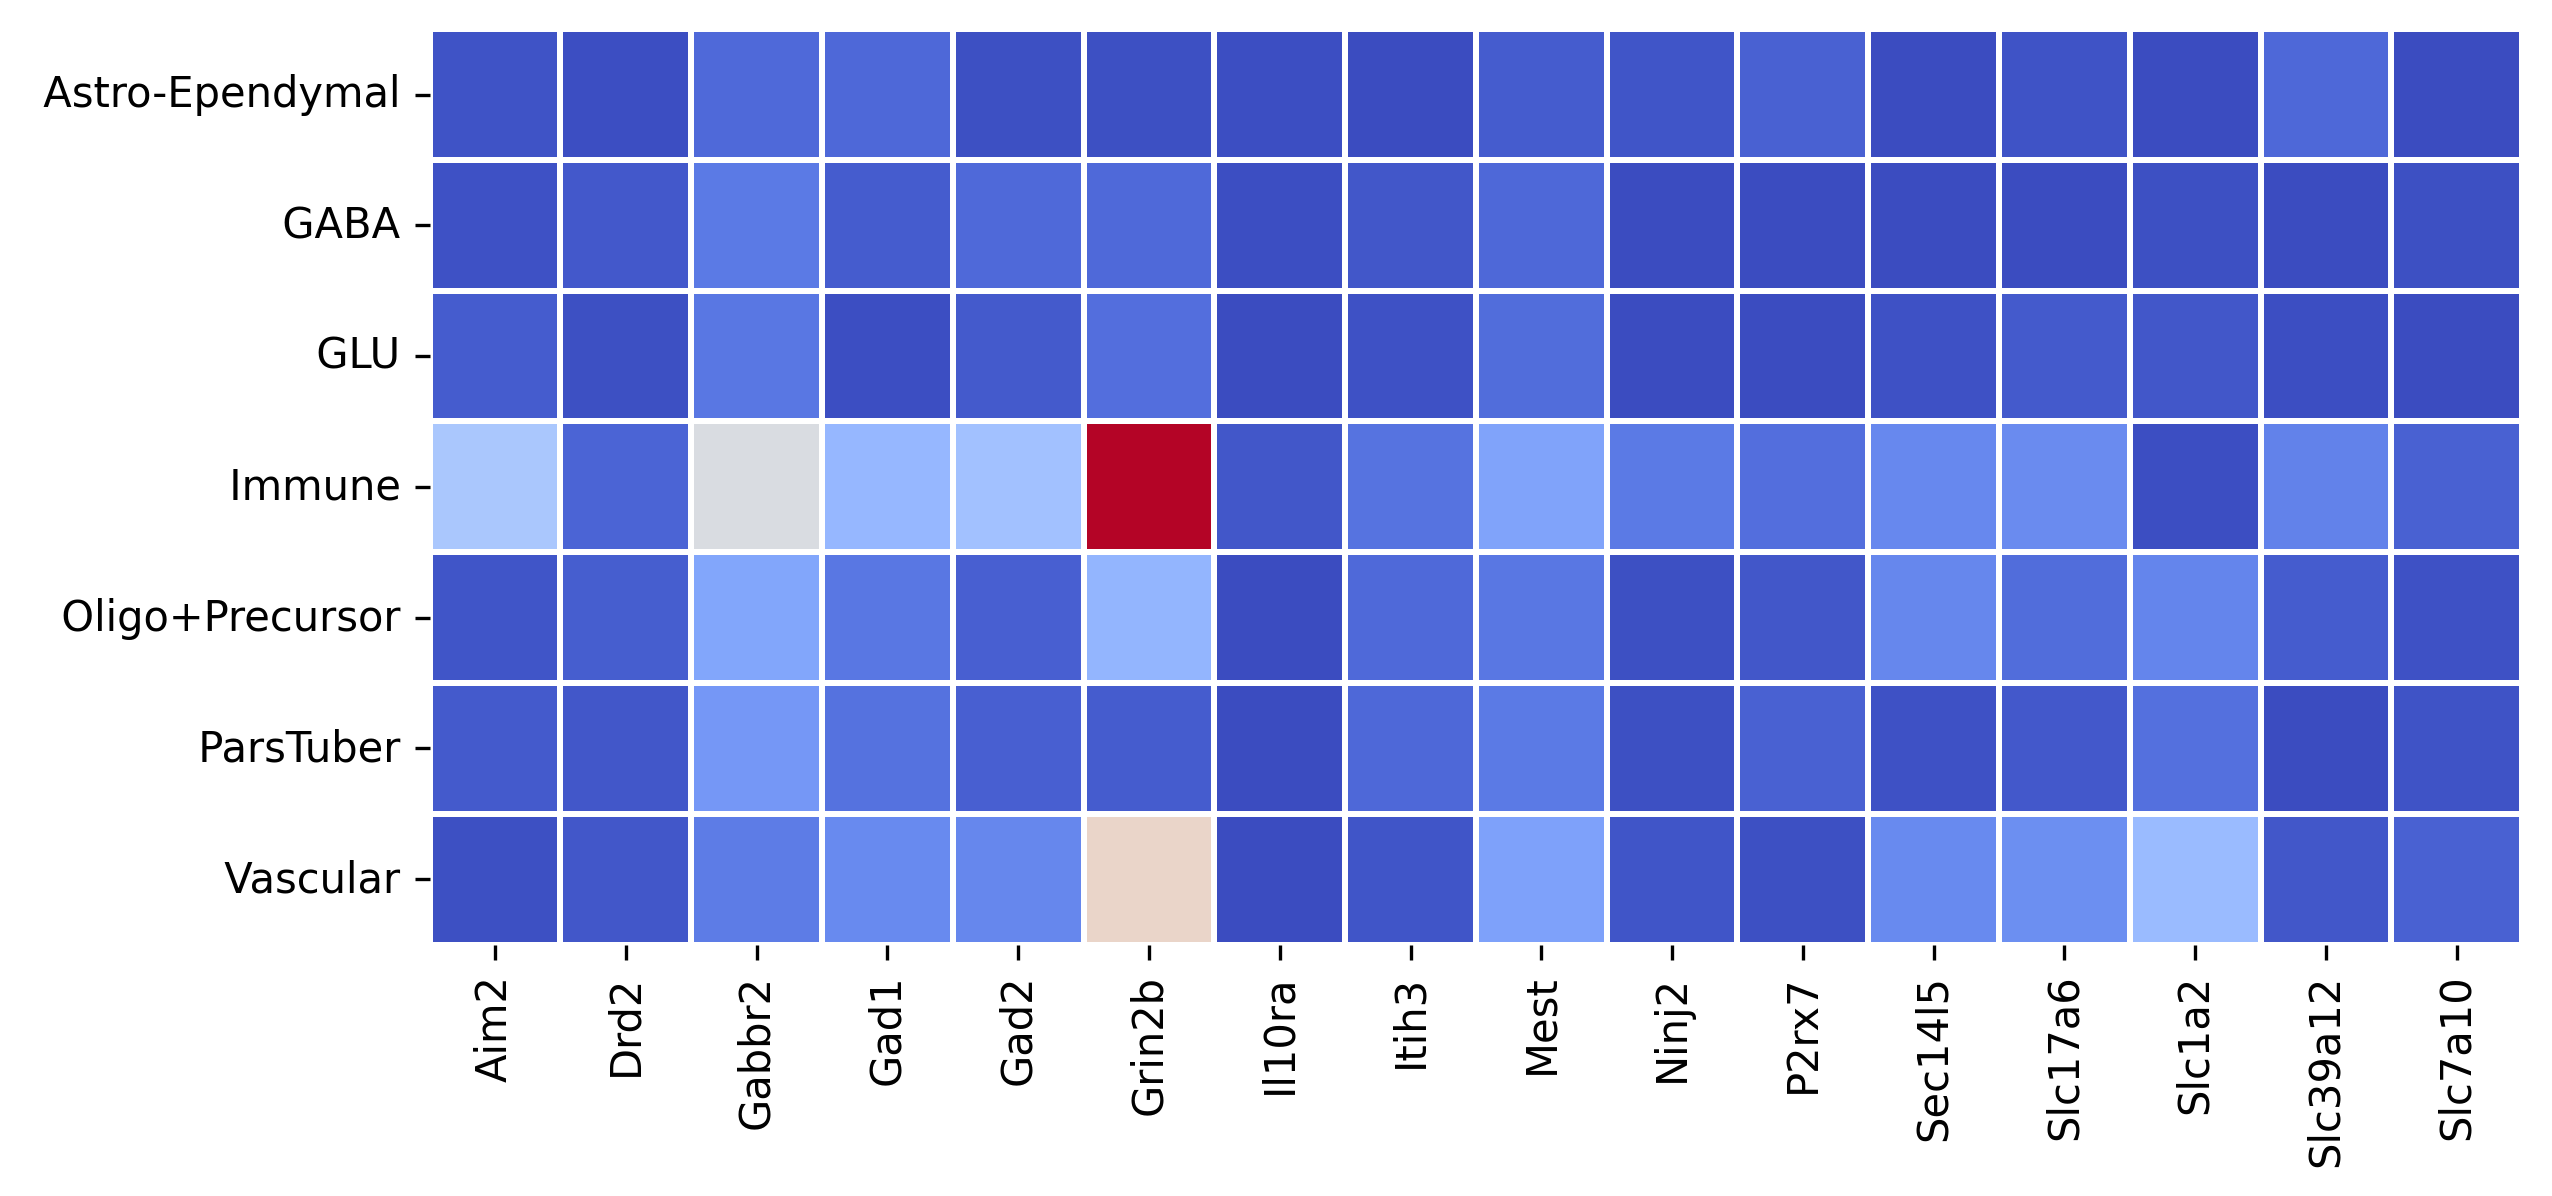

In [14]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

sns.heatmap(pdf.T,
            cmap='coolwarm',
            lw=1,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
# ut.makeColorbar('coolwarm', 0.2, 3, "Abs. Fold Change (log)", 'vertical', ['0', '0.5'])

In [15]:
""" Distribution of marker gene expression """
query = [
    'Mc3r', 
    "Agrp", 
    "Npy", 
    "Nr5a1", 
    "Pomc", 
    "Mc4r", 
    "Gnrhr", 
    "Gnrh1", 
    "Ghrh", 
    "Ghrhr", 
    "Sst", 
    "Esr1",
    "Lepr",
    "Pnoc",
    "Adcyap1",
    "Foxp2", 
    "Dlk1",
    "Kiss1", 
    "Tac2", 
    "Pdyn", 
    "Rprm",
    "Oxtr",
    "Drd2",
    "Gria3", 
    "Grik1", 
    "Grik3", 
    "Gabra5", 
    "Gabra2", 
    "Syndig1",
    "Pak3",
    "Ptk2b", 
    "Plk2",
    "Trh",
    "Glp1r",
]


"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

for ctype, group in pdf.groupby('C25_named_clean'):
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)

    # print(f"{ctype} {p.shape=} {n.shape=}")

    ex = pd.concat([p[query].mean(), n[query].mean()], axis=1)
    ex.columns = ['positive', 'negative']

    
    ex['ctype'] = ctype
    ex = ex.reset_index(drop=False)

    ex['logfoldchange'] = ex[['positive', 'negative']].apply(lambda x: np.log1p(x[0]) - np.log1p(x[1]), axis=1)

    res.append(ex)
    # break

res = pd.concat(res)
res = pd.melt(res, id_vars=['ctype', 'index'], value_vars='logfoldchange')
res.head()

pos.shape=(21714, 34) neg.shape=(21223, 34)
(42937, 51)


,ctype,index,variable,value
0,Astrocytes,Mc3r,logfoldchange,-0.000396
1,Astrocytes,Agrp,logfoldchange,0.005018
2,Astrocytes,Npy,logfoldchange,0.000232
3,Astrocytes,Nr5a1,logfoldchange,0.005902
4,Astrocytes,Pomc,logfoldchange,-0.023702


ctype
 Astrocytes           0.132719
 Ependymal-like       0.115511
 Fibroblasts          0.458049
 GABA-2               0.045387
 GABA-3               0.057632
 GABA-4               0.064505
 GABA-5               0.066688
 GABA-6               0.074376
 GABA-7               0.056874
 GLU-1                0.120532
 GLU-2                0.063437
 GLU-3                0.046503
 GLU-5                0.087935
 GLU-6                0.302244
 GLU-7                0.121637
 GLU-8                0.062794
 Immune               0.366532
 Mural+Endothelial    0.205595
 OPC                  0.113361
 Oligodendrocytes     0.121968
 ParsTuber            0.065093
dtype: float64


Text(0.5, 456.09523809523813, '')

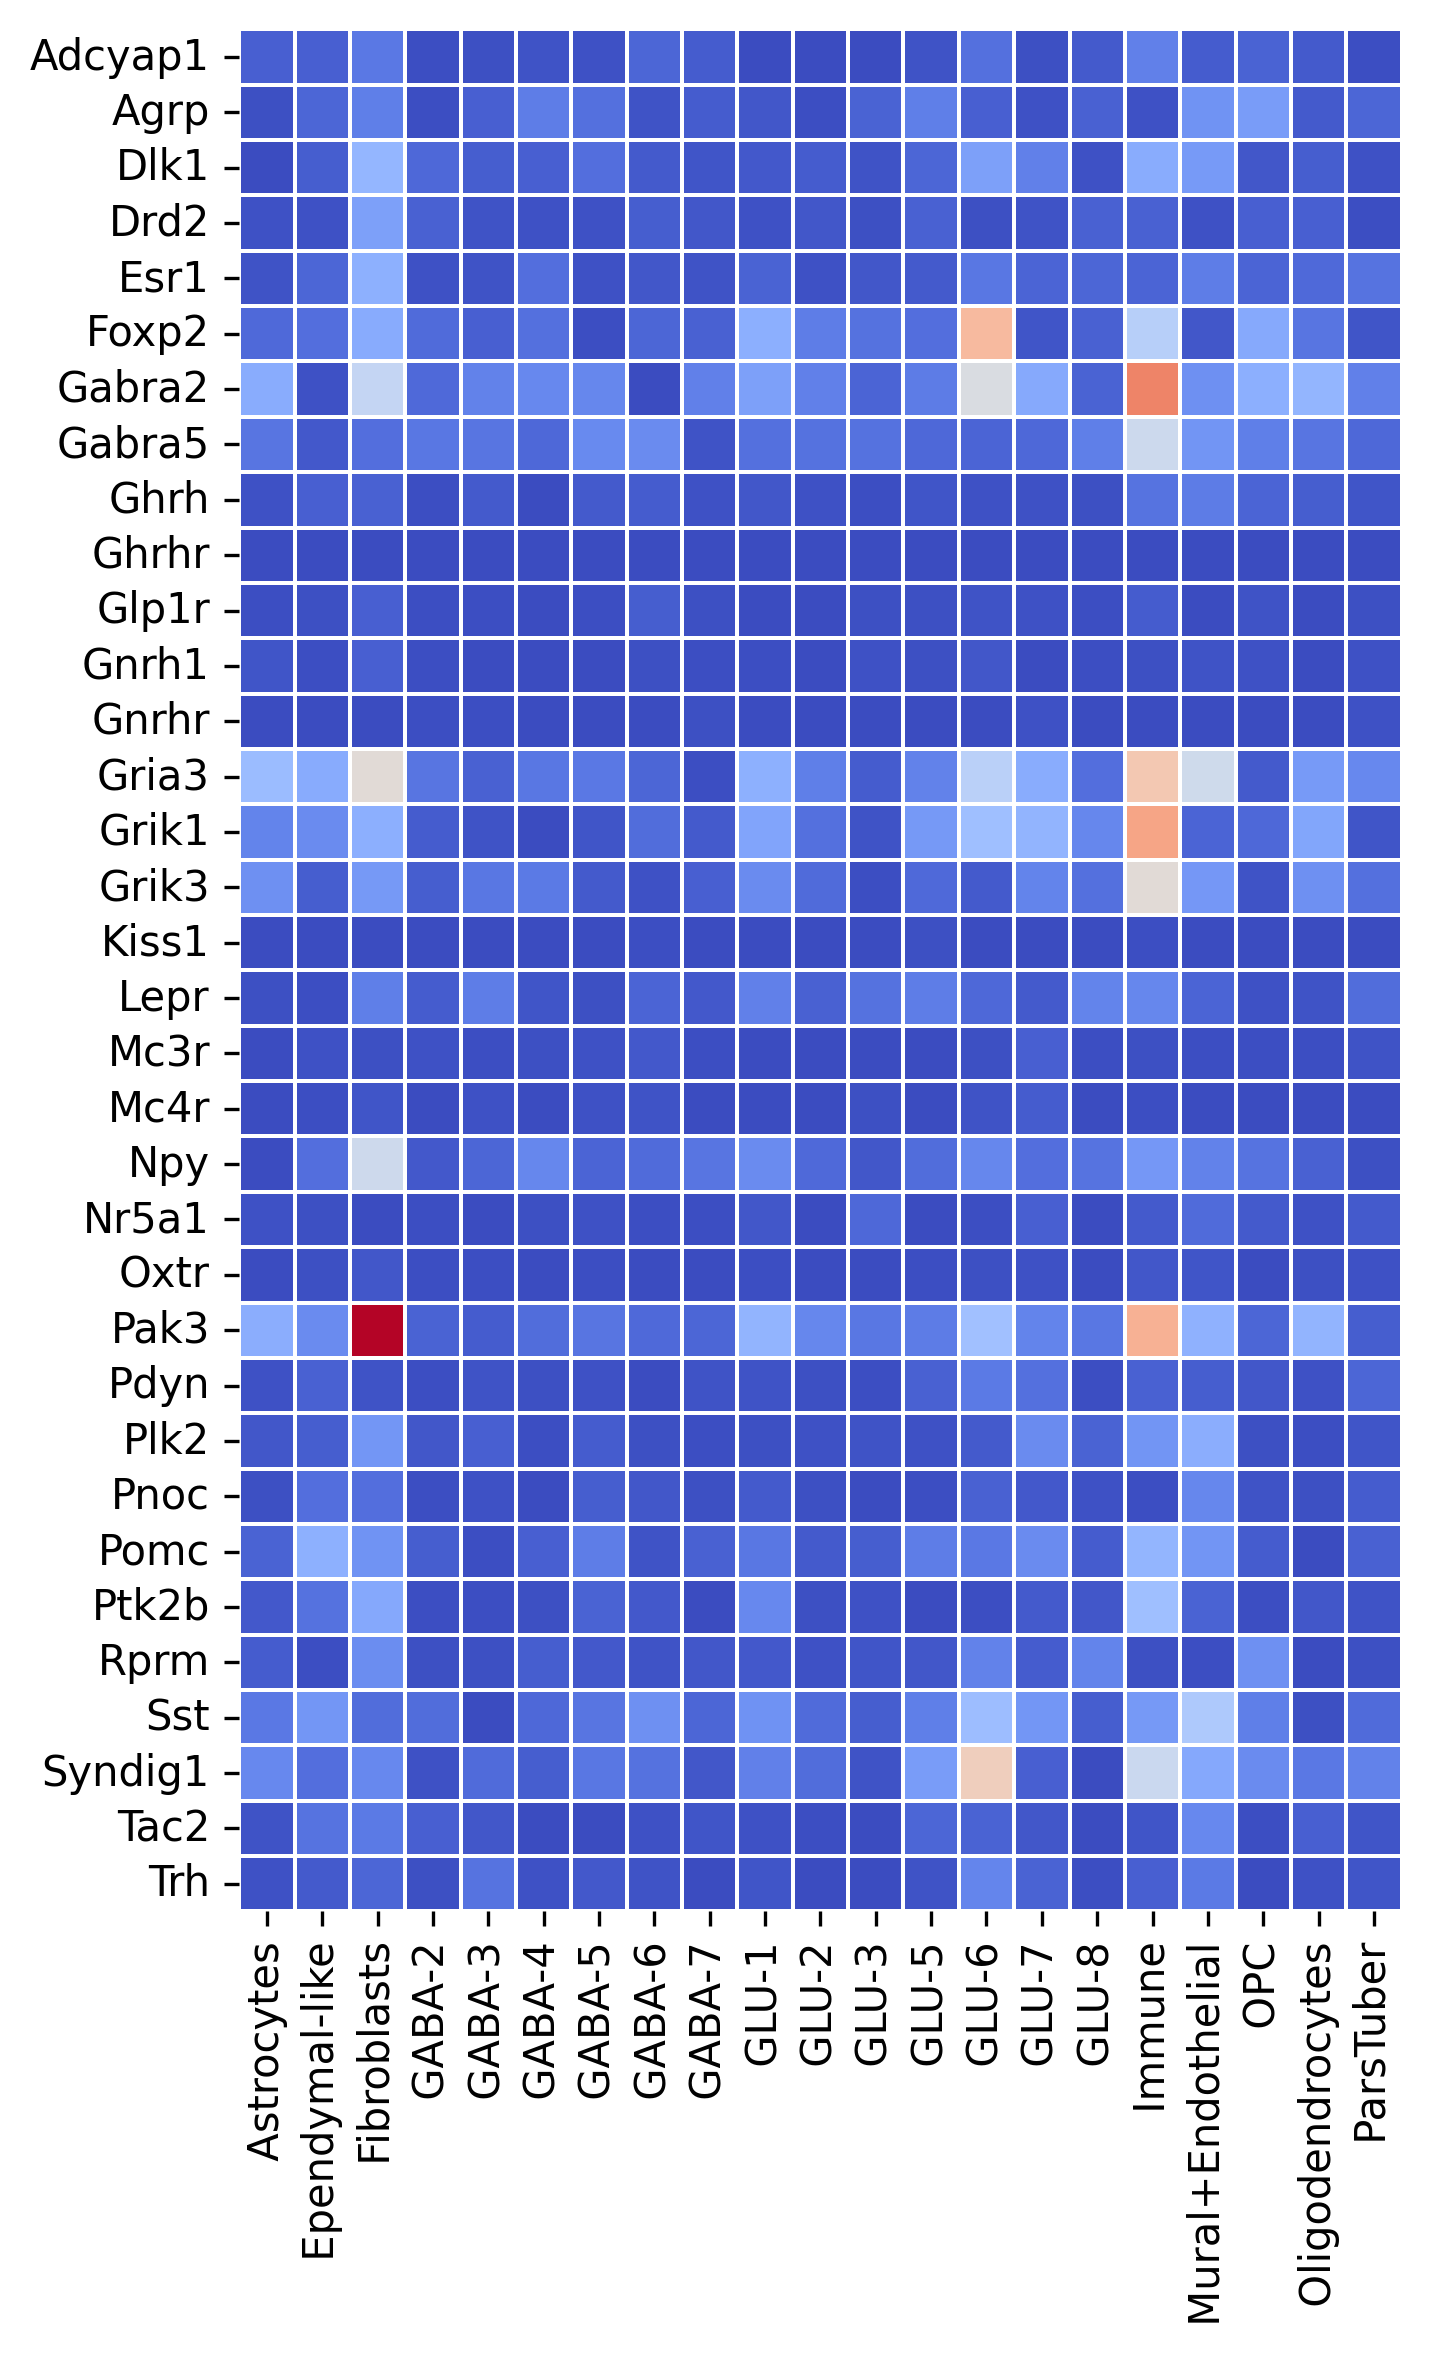

In [16]:
pdf = pd.pivot_table(res, index='index', columns='ctype',
                 values='value')

pdf = np.abs(pdf)
print(pdf.max())

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 10

sns.heatmap(pdf,
            cmap='coolwarm',
            lw=0.5,
            cbar=False,
            square=True)

plt.ylabel("")
plt.xlabel("")

In [ ]:
break

In [75]:
"""Randomly sampled genes """

sample_n = 5000
query = np.random.choice(adata.var_names, sample_n, replace=False)

"""Extract expression for marker genes """
mask = (adata.obs['sun1'] == 1)
pos_ind = adata.obs[mask].index.to_list()
neg_ind = adata.obs[~mask].index.to_list()

pos = adata[pos_ind, query].to_df()
neg = adata[neg_ind, query].to_df()

print(f"{pos.shape=} {neg.shape=}")

pdf = pd.concat([pos, neg])

pdf = pd.merge(pdf, adata.obs,
               how='left',
               left_index=True,
               right_index=True)

print(f"{pdf.shape}")
                
res = []

allcount = 0
for ctype, group in pdf.groupby('C7_named_clean'):
    print(f"working... {ctype}")
    mask = (group['sun1'] == 1)
    p = group[mask].reset_index(drop=False)
    n = group[~mask].reset_index(drop=False)
    allcount += p.shape[0]

    for g in query:

        score, pval = scipy.stats.ranksums(p[g], n[g])
        # score, pval = scipy.stats.ttest_ind(p[g], n[g])

        pos_mean = p[g].mean()
        neg_mean = n[g].mean()
        lfc = np.log2(pos_mean + 1) - np.log2(neg_mean + 1)
        
        row = {
            'celltype' : ctype,
            'gene' : g,
            'score' : score, 
            'pval' : pval,
            'log2foldchange' : lfc,
            'sun1_pos_mean' : pos_mean,
            'sun1_neg_mean' : neg_mean,
            'sun1_pos_std' : p[g].std(),
            'sun1_neg_std' : n[g].std(),
            'sun1_pos_n' : len(p[g]),
            'sun1_neg_n' : len(n[g]),
            # 'sun1_pos_reads' : adata[p.index.to_list(), [g]].layers['counts'].sum(),
            # 'sun1_neg_reads' : adata[n.index.to_list(), [g]].layers['counts'].sum(),
        }
        res.append(row)

        
res = pd.DataFrame(res)
res.head()
# allcount

pos.shape=(21714, 5000) neg.shape=(21223, 5000)
(42937, 5017)
working...  Astro-Ependymal
working...  GABA
working...  GLU
working...  Immune
working...  Oligo+Precursor
working...  ParsTuber
working...  Vascular


,celltype,gene,score,pval,log2foldchange,sun1_pos_mean,sun1_neg_mean,sun1_pos_std,sun1_neg_std,sun1_pos_n,sun1_neg_n
0,Astro-Ependymal,Gm15124,-1.756943,0.078928,0.002494,0.002735,0.001003,0.057450,0.041700,433,1662
1,Astro-Ependymal,Il11ra1,-0.017527,0.986016,-0.002972,0.143977,0.146336,0.423556,0.446103,433,1662
2,Astro-Ependymal,Snx8,-1.700037,0.089124,-0.003722,0.039723,0.042409,0.218319,0.235880,433,1662
3,Astro-Ependymal,Lrrc26,0.304508,0.760741,-0.000002,0.000018,0.000020,0.000053,0.000052,433,1662
4,Astro-Ependymal,9630009A06Rik,-1.593986,0.110939,0.011870,0.011210,0.002924,0.118063,0.077620,433,1662


Text(0.5, 0, '$p$-value')

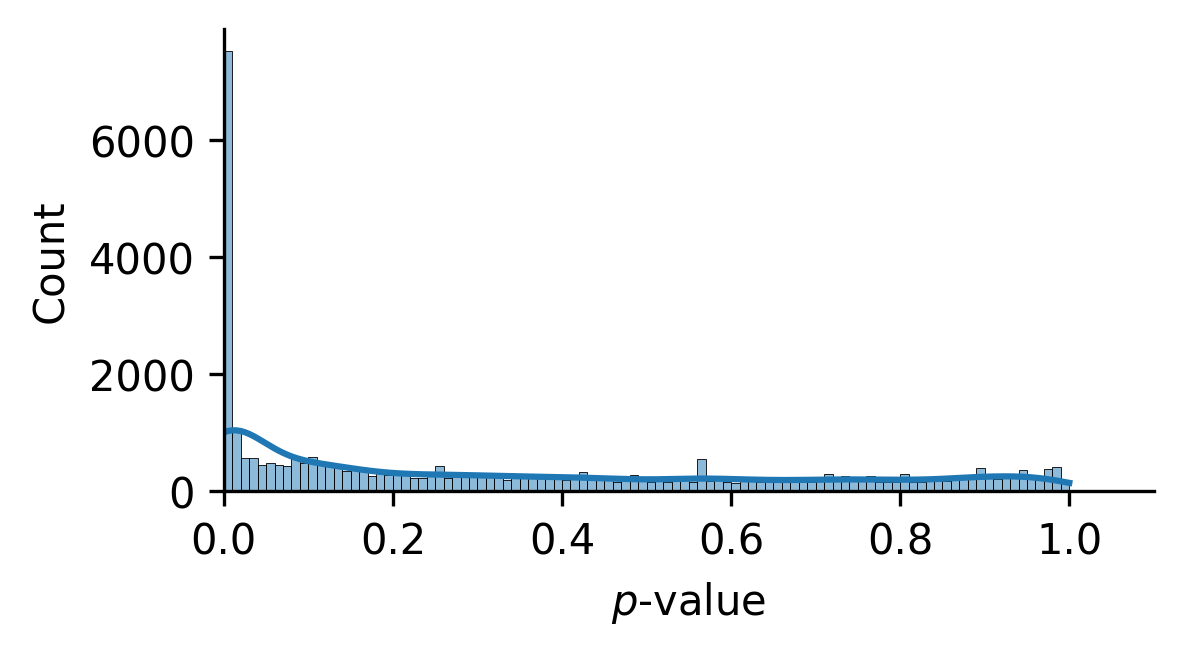

In [76]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.histplot(data=res, 
             x='pval',
             bins=100,
             kde=True,)
             # hue='celltype',
             # log_scale=True)

sns.despine()
# sns.move_legend(plt.gca(), 
#                 title="",
#                 frameon=False,
#                 loc='upper right',
#                 bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 1.1])
plt.xlabel(r"$p$-value")


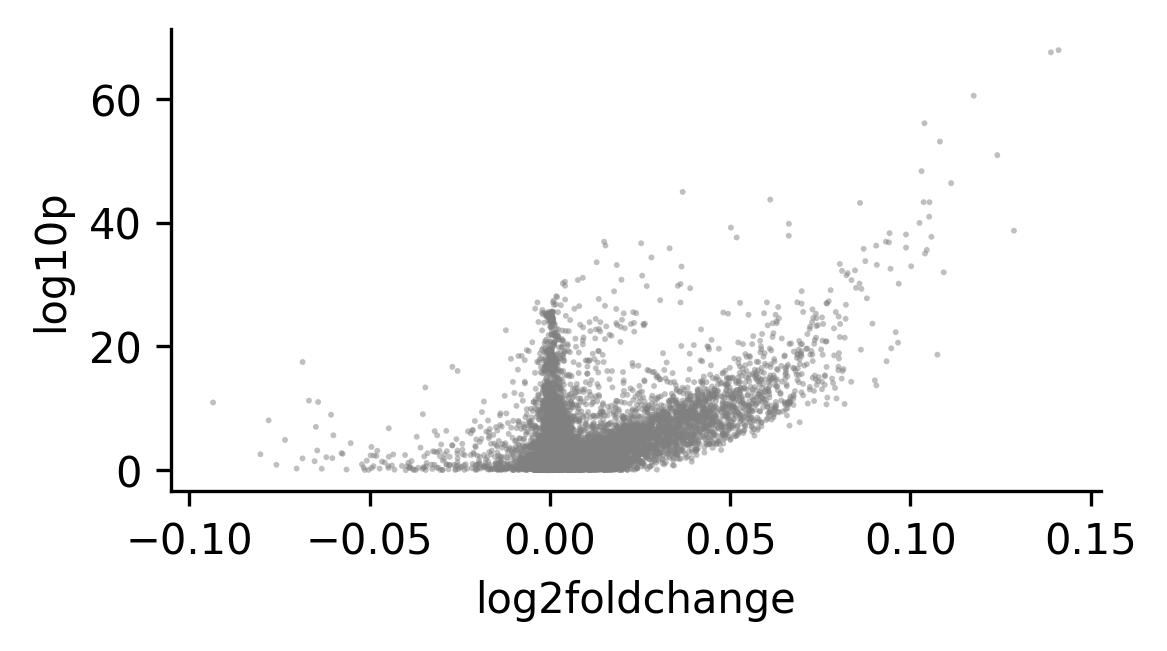

In [109]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')
neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf['log10p'] = -1 * np.log10(pdf['pval'])


sns.scatterplot(data=pdf, 
                x='log2foldchange',
                y='log10p',
                ec='none',
                color='grey',
                s=2,
                alpha=0.5)

pdf.head()
sns.despine()

In [95]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

n_query = 500
ascending = False # false means highest upregulated  in sun1+

alpha = 0.05
ntests = len(pdf)
alphaHat = 1 - ((1-alpha) ** (1/ntests))
print(f"{alphaHat}")

pdf = pdf[pdf['pval'] <= alphaHat]
print(pdf['celltype'].value_counts())
print()

neuro = [' GABA', ' GLU']
pdf = pdf[pdf['celltype'].isin(neuro)]

pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
print(pdf.head())

query_genes = list(pdf['gene'].head(n_query).unique())

# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(query_genes, database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)

# outpath = "GABA_GLU_Sun1_positive_downregulated_genes.csv"
# edf.to_csv(outpath, index=False)

edf[['path_name', 'adj_p_val', 'overlapping_genes']]

Thu Sep 28 11:54:52 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


1.4655216229453316e-06
 GLU                2464
 GABA                783
 Immune               92
 Oligo+Precursor      41
 Vascular              4
Name: celltype, dtype: int64

      celltype     gene      score          pval  log2foldchange  \
10854      GLU  Gm1604a  17.499450  1.446599e-68        0.141101   
13889      GLU    Lcorl  17.453974  3.210946e-68        0.138986   
10916      GLU   Hs3st4  13.135084  2.072614e-39        0.128724   
12143      GLU    Plcb1  15.114309  1.303306e-51        0.124104   
14453      GLU    Kcnq3  16.507376  3.246979e-61        0.117565   

       sun1_pos_mean  sun1_neg_mean  sun1_pos_std  sun1_neg_std  sun1_pos_n  \
10854       0.775503       0.610074      0.670782      0.680253       12780   
13889       1.148373       0.951060      0.761361      0.803888       12780   
10916       1.322485       1.124238      1.043792      1.074731       12780   
12143       1.344796       1.151523      0.852669      0.913069       12780   
14453       1.7113

,path_name,adj_p_val,overlapping_genes
0,protein localization to plasma membrane (GO:0072659),0.020693,"[SPTBN4, CCDC88A, RAB40B, PACS1, KCNB2, FCHO2, TTC7B, MAP7, TSPAN5, MYO5A, RAPGEF2]"
1,cellular calcium ion homeostasis (GO:0006874),0.020693,"[RYR2, SLC24A3, STIM1, TRPC4, CHRNA7, TRPC1, NPTN, ATP2B1, ATP13A3, SLC8A1, HCRTR2]"
2,regulation of protein phosphorylation (GO:0001932),0.034142,"[SPTBN4, TFRC, CHRNA7, KNDC1, CCDC88A, SLCO3A1, NSD1, DNAJC10, LEPR, NPTN, DVL3, SLIT2, EPHB2, FNIP1, FNIP2]"
3,cellular metal ion homeostasis (GO:0006875),0.034142,"[RYR2, SLC24A3, STIM1, CHRNA7, KCNMA1, NPTN, ATP2B1, ATP13A3, SLC8A1]"
4,protein localization to cell periphery (GO:1990778),0.044182,"[SPTBN4, RAB40B, PACS1, KCNB2, FCHO2, TTC7B, MAP7, TSPAN5, MYO5A, RAPGEF2]"
5,positive regulation of cell projection organization (GO:0031346),0.044182,"[GRIP1, TIAM1, CUX1, NPTN, DVL3, MAP6, RAPGEF2, SLIT2, ARHGAP35]"
6,regulation of dendrite morphogenesis (GO:0048814),0.044182,"[GSK3B, CUX1, HECW2, RAPGEF2, KNDC1]"
7,axon guidance (GO:0007411),0.044182,"[ENAH, SPTBN4, DAB1, NPTN, UNC5C, EVL, PIK3R1, CNTN4, SLIT2, EPHB2, SHANK3, ARHGAP35]"
8,negative regulation of supramolecular fiber organization (GO:1902904),0.044182,"[ARFGEF1, NAV3, TBCD, SLIT2, SSH2, SHANK3, CAMSAP2]"
9,calcium ion homeostasis (GO:0055074),0.044182,"[RYR2, SLC24A3, STIM1, CHRNA7, NPTN, ATP2B1, ATP13A3, SLC8A1]"


In [113]:
outpath = "GABA_GLU_Sun1_positive_DEG.csv"
pdf.to_csv(outpath, index=False)
pdf = pdf.sort_values(by='log2foldchange', ascending=ascending)
pdf.head(50)

,celltype,gene,score,pval,log2foldchange,sun1_pos_mean,sun1_neg_mean,sun1_pos_std,sun1_neg_std,sun1_pos_n,sun1_neg_n,log10p
10854,GLU,Gm1604a,17.499450,1.446599e-68,0.141101,0.775503,0.610074,0.670782,0.680253,12780,8469,67.839652
13889,GLU,Lcorl,17.453974,3.210946e-68,0.138986,1.148373,0.951060,0.761361,0.803888,12780,8469,67.493367
10916,GLU,Hs3st4,13.135084,2.072614e-39,0.128724,1.322485,1.124238,1.043792,1.074731,12780,8469,38.683482
12143,GLU,Plcb1,15.114309,1.303306e-51,0.124104,1.344796,1.151523,0.852669,0.913069,12780,8469,50.884954
14453,GLU,Kcnq3,16.507376,3.246979e-61,0.117565,1.711352,1.499168,0.761945,0.865324,12780,8469,60.488521
12479,GLU,Kcnh5,14.411269,4.395567e-47,0.111300,0.543583,0.428977,0.576418,0.584835,12780,8469,46.356985
13001,GLU,Gm12239,11.905395,1.109364e-32,0.109249,0.460660,0.354135,0.596885,0.580363,12780,8469,31.954926
14155,GLU,Kcnb2,15.442632,8.457698e-54,0.108176,2.083683,1.860919,0.884937,0.983997,12780,8469,53.072748
5711,GABA,A830018L16Rik,9.003552,2.185312e-19,0.107494,0.907159,0.770224,0.859433,0.858956,7478,6374,18.660487
13064,GLU,Dock10,12.961321,2.027261e-38,0.105822,0.924027,0.787951,0.735797,0.777885,12780,8469,37.693090


In [74]:
# pdf = res.copy()
# pdf = pdf.sort_values(by='celltype')

# alpha = 0.05
# ntests = len(pdf)
# alphaHat = 1 - ((1-alpha) ** (1/ntests))
# print(f"{alphaHat}")

# pdf = pdf[pdf['pval'] <= alphaHat]
# print(pdf['celltype'].value_counts())
# print()

# new_query = pdf[pdf['celltype'] == ' GABA']
# new_query


In [72]:
# db = 'GO_Biological_Process_2023'
db = 'GO_Biological_Process_2021'
# db = 'KEGG_2021_Human'
# db = 'TRANSFAC_and_JASPAR_PWMs'

e_alpha = 0.05

edf = gget.enrichr(list(new_query['gene'].unique()), database=db)
edf = edf[edf['adj_p_val'] <= e_alpha]
pd.set_option('display.max_colwidth', 150)
edf[['path_name', 'adj_p_val', 'overlapping_genes']]

Thu Sep 28 11:42:38 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


,path_name,adj_p_val,overlapping_genes
0,axonogenesis (GO:0007409),0.048326,"[EPHA4, EPHA6, CNTN6, DCC, PLPPR4, DOCK7, SEMA4F, ANK3, VLDLR, GAB2, PIK3CB, ENAH, RAB10, KLF7, DAB1, GRB10, MAPK1, FYN, EPHB2, PAK3, B4GALT6, EPH..."


(0.0, 0.05)

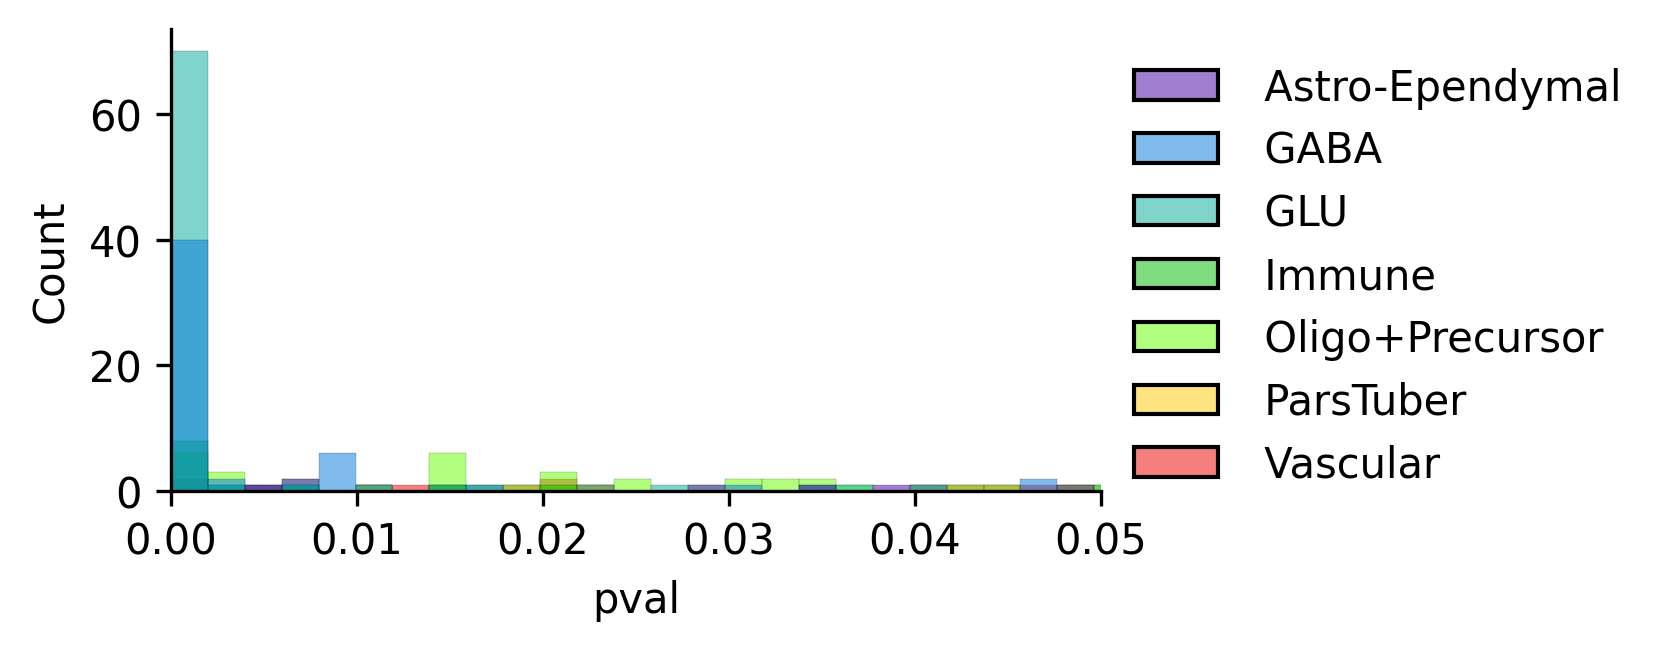

In [21]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2

pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

sns.kdeplot(data=res, 
             x='pval',
             # bins=500,
             # kde=True,
             palette='nipy_spectral',
             hue='celltype',)
             # log_scale=True)

sns.despine()
sns.move_legend(plt.gca(), 
                title="",
                frameon=False,
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

plt.xlim([0.0, 0.05])



In [ ]:
pdf = res.copy()
pdf = pdf.sort_values(by='celltype')

alpha_threshold = 

pdf.head()

In [ ]:
# p = pd.pivot_table(pdf, index=['C7_named_clean', 'Diet', 'Sex', 'Sun1'], 
#                     columns=query, 
#                     values=query,
#                     aggfunc='mean').reset_index(drop=False)

# print(f"{p.shape=}")
# print(p.head())

In [ ]:
break

In [ ]:
break

In [ ]:
gene = 'Sun1'
mask = (adata[:, [gene]].layers['counts'].todense() > 0)
gene_pos = adata.obs[mask]
print(f"{gene_pos.shape=}")
counts = gene_pos['broad_type'].value_counts().reset_index()

counts = counts.sort_values(by='index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

total_counts = adata.obs['broad_type'].value_counts().reset_index()
total_counts = total_counts.sort_values(by='index')

sns.barplot(data=total_counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k',
            )

ax = plt.gca()

plt.ylabel("")
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("right", size="100%", pad="10%")

sns.barplot(data=counts, 
            y='index',
            x='broad_type',
            palette='nipy_spectral',
            ec='k')

ax2.set_ylabel("")
ax2.set_yticks([])
ax2.set_yticklabels([])

ax2.set_xlabel("n Cells")
ax.set_xlabel("n Cells")

ax.set_title("All Cells")
ax2.set_title("Mc3r+ Cells")

ax2.set_xscale('log')
ax.set_xscale('log')

print(counts)


sns.despine()

In [ ]:

sample_size = 100
ctype = ' GLU'
gene = 'Sun1'
condition = 'fed_m'

obs = adata.obs.copy()

# add a binary flag for a target gene
obs['flag'] = np.ravel((adata[:, [gene]].layers['counts'] > 0).todense())

type_mask = (obs['broad_type'] == ctype) & (obs['batch'] == condition)
obs = obs[type_mask]

print(f"{obs.shape=}")
print(obs['flag'].value_counts())

# binary flag the cells
mask = (obs['flag'] == True)

pos = obs[mask].sample(sample_size).index
neg = obs[~mask].sample(sample_size).index


print(f"{pos.shape=}")
print(f"{neg.shape=}")

X1 = pd.DataFrame(adata[pos.to_list(), :].obsm['X_pca'].T).corr()
X2 = pd.DataFrame(adata[neg.to_list(), :].obsm['X_pca'].T).corr()

print(f"{X1.shape=}")
print(f"{X2.shape=}")

fig, axs = plt.subplots(1, 2)

axs[0].imshow(X1)
axs[0].set_title("Sun1+")

axs[1].imshow(X2)
axs[1].set_title("Sun1-")

In [ ]:
X1_corrs = np.triu(X1, k=1).ravel()
X2_corrs = np.triu(X2, k=1).ravel()


kres = scipy.stats.ks_2samp(X1_corrs, X2_corrs)
print(kres)

pdf = pd.DataFrame({'Sun1+' : X1_corrs,
                    'Sun1-' : X2_corrs,})

pdf = pd.melt(pdf)


sns.histplot(data=pdf, 
             x='value',
             hue='variable',
             bins=100)

plt.yscale('log')
plt.xlabel("Correlation")
plt.ylabel("Count")

sns.move_legend(plt.gca(), 
                loc='upper right',
                title="",
                frameon=False, 
                bbox_to_anchor=(1, 1))

sns.despine()


In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')

deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [ ]:
outpath = "/nfs/turbo/umms-indikar/shared/projects/MC3R/results/all_batch_DEG.csv"
res.to_csv(outpath, index=False)
res.head()

In [ ]:
print(adata.obs["broad_type"] .value_counts())

""" Subset the nuerons """
# ctypes = [' GLU', ' GABA']
ctypes = [' GABA']
ndata = adata[adata.obs["broad_type"].isin(ctypes)].copy()

sc.tl.rank_genes_groups(ndata, 
                        groupby='batch', 
                        method='wilcoxon',
                        key_added='pairwise_batch',
                        corr_method='benjamini-hochberg') 

sc.pl.rank_genes_groups(ndata, 
                        n_genes=20, 
                        key='pairwise_batch',
                        sharey=False,
                        ncols=2)



In [ ]:
deg = sc.get.rank_genes_groups_df(ndata, 
                                  group=None,
                                  key='pairwise_batch')

print(f"{deg.shape=}")
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1
label_n = 5


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 4
fig, axs =  plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=4,)


title_map = {
    'fasted_f' : "Male-Fed", 
    'fasted_m' : "Male-Fasted",
    'fed_f' :  "Female-Fed",
    'fed_m' : "Female-Fasted",
}

res = []

for i, group in enumerate(deg['group'].unique()):
    # subset group of interest
    pdf = deg[deg['group'] == group].reset_index(drop=True)

    mask = (pdf['logfoldchanges'] > -2) & (pdf['logfoldchanges'] < 2) & (pdf['pvals'] <= alpha)
    pdf = pdf[mask].reset_index(drop=True)

    sns.scatterplot(data=pdf, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                ax=axs[i],
                s=5)

    mask = (pdf['logfoldchanges'] < -thresh) | (pdf['logfoldchanges'] > thresh)
    hi_deg = pdf[mask].reset_index(drop=True)
    print(f"{group=} {hi_deg.shape=}")

    res.append(hi_deg)

    sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                ax=axs[i],
                s=5)

    axs[i].axvline(x=thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].axvline(x=-thresh, lw=1, c='k', ls=':', zorder=3)
    axs[i].set_yticks([], [])

    label_point(hi_deg['logfoldchanges'].head(label_n), 
                hi_deg['log10p'].head(label_n), 
                hi_deg['names'].head(label_n), 
                axs[i]) 


    label_point(hi_deg['logfoldchanges'].tail(label_n), 
            hi_deg['log10p'].tail(label_n), 
            hi_deg['names'].tail(label_n), 
            axs[i]) 

    if i == 0 or i == 2:
        axs[i].set_ylabel(r"-log$_{10}$($p$-value)")
    else:
        axs[i].set_ylabel("")

    if i == 2 or i == 3:
        axs[i].set_xlabel(r"Fold Change (log$_{2}$)")
    else:
        axs[i].set_xlabel("")

    axs[i].set_title(title_map[group])

res = pd.concat(res)
print(f"{res.shape=}")

plt.tight_layout()
sns.despine()

In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Sex', 
                        method='wilcoxon',
                        key_added='sex',
                        corr_method='bonferroni') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='sex',
                        sharey=False)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='pairwise_batch')


deg = deg[deg['group'] == 'f'].reset_index(drop=True)
deg['log10p'] = -1 * np.log10(deg['pvals'])
alpha = 0.05
thresh = 1

mask =  (deg['logfoldchanges'] > -2) & (deg['logfoldchanges'] < 2) & (deg['pvals'] <= alpha)
deg = deg[mask].reset_index(drop=True)


plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.scatterplot(data=deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='grey',
                zorder=1,
                s=5)

mask = (deg['logfoldchanges'] < -thresh) | (deg['logfoldchanges'] > thresh)

hi_deg = deg[mask].reset_index(drop=True)
print(f"{hi_deg.shape=}")

sns.scatterplot(data=hi_deg, 
                x='logfoldchanges',
                y='log10p',
                ec='none',
                alpha=0.6,
                color='r',
                zorder=2,
                s=5)

plt.axvline(x=thresh, lw=1, c='k', ls=':', zorder=0)
plt.axvline(x=-thresh, lw=1, c='k', ls=':', zorder=0)
plt.yticks([], [])
plt.ylabel(r"-log$_{10}$($p$-value)")
plt.xlabel(r"Fold Change (log$_{2}$)")
sns.despine()

In [ ]:
hi_deg.sort_values(by='logfoldchanges')

In [ ]:
break

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='Diet', 
                        method='wilcoxon',
                        key_added='diet',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='diet',
                        sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='broad_type', 
                        method='wilcoxon',
                        key_added='broad_type',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='broad_type',
                        sharey=False,
                        ncols=3)

In [ ]:
sc.tl.rank_genes_groups(adata, 
                        groupby='reference_embedding_C25_named_clean', 
                        method='wilcoxon',
                        key_added='subtype',
                        corr_method='benjamini-hochberg') # default correctiong is bengamin

sc.pl.rank_genes_groups(adata, 
                        n_genes=20, 
                        key='subtype',
                        sharey=False,
                        ncols=3)

In [ ]:
deg = sc.get.rank_genes_groups_df(adata, 
                                  group=None,
                                  key='sex')

deg.head()

In [ ]:
# NOW for some exploration of Mc3r+ cells